In [34]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# Specific tf libraries
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
# BOOST
import xgboost
import lightgbm


In [2]:
pd.options.mode.chained_assignment = None

In [3]:
%run ../common_utils.py

## 1 - BAGGING
Use the average of the predictions over the models, instead of using just one.
- Stacking! Wohoo. Probably smart to have a deep learning model in the stack.

In [5]:
# All their kaggle scores
d = {'LaureRF': 0.20015,
     'Deep': 0.23278,
     'GB': 0.19968,
     'CB1': 0.23450,
     'XGB1': 0.23787,
     'KNN1' : 0.35042}

acc = pd.DataFrame(
    d,
    index=[0]
)
acc = acc.T
acc.columns = ['RMSLE']
acc

,RMSLE
LaureRF,0.20015
Deep,0.23278
GB,0.19968
CB1,0.23450
XGB1,0.23787
KNN1,0.35042


In [6]:
LaureRF = pd.read_csv("ensemble_predictions/LaureRF.csv")
Deep = pd.read_csv("ensemble_predictions/Deep.csv")
GB = pd.read_csv("ensemble_predictions/GB.csv")
CB1 = pd.read_csv("ensemble_predictions/CB1.csv")
XGB1 = pd.read_csv("ensemble_predictions/XGB1.csv")
KNN1 = pd.read_csv("ensemble_predictions/KNN1.csv")

In [7]:
LaureRF = LaureRF.sort_values(by="id")
Deep = Deep.sort_values(by="id")
GB = GB.sort_values(by="id")
CB1 = CB1.sort_values(by="id")
XGB1 = XGB1.sort_values(by="id")
KNN1 = KNN1.sort_values(by="id")

In [8]:
LaureRF_prediction = LaureRF["price_prediction"].to_numpy().T
Deep_prediction = Deep["price_prediction"].to_numpy().T
GB_prediction = GB["price_prediction"].to_numpy().T
CB1_prediction = CB1["price_prediction"].to_numpy().T
XGB1_prediction = XGB1["price_prediction"].to_numpy().T
KNN1_prediction = KNN1["price_prediction"].to_numpy().T

In [9]:
avg_prediction = np.average(
    [LaureRF_prediction,
     Deep_prediction,
     GB_prediction,
     CB1_prediction,
     XGB1_prediction,
     KNN1_prediction
    ],
    weights = 1 / acc['RMSLE'] ** 4,
    axis=0
)

In [35]:
result = avg_prediction
submission = pd.DataFrame()
submission['id'] = LaureRF['id']
submission['price_prediction'] = result
if len(submission['id']) != 9937:
    raise Exception("Not enough rows submitted!")
submission.to_csv('BESTSUBMISSIONEVER', index=False)

## 2 - Stacking
The more sofisticated way of ensemble the models.
Analogy: A king listening to advisors, and using their advise to make desicions.

In [177]:
%run ../common_utils.py

In [178]:
train, test, metaData = load_all_data()

### Deep learning advisor

In [179]:
# Mostly the ones correlated to price.
features =           ["building_id",
                      "area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

train_labels, train_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True",  add_spacious=True, droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

Hot encoding
minMax


In [180]:
model_params = ([18, 12, 6], tf.nn.relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tf.keras.metrics.Accuracy()], True)

In [181]:
# NB! We cannot just compile ann model beforehand, will just keep training on same model.
ann_oof_train, ann_oof_test, hists = get_oof_ann(model_params, train_labels, train_targets, test_labels)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................................Epoch 00293: early stopping

....................................................................................................
....................................................................................................
.....................................................................

In [182]:
# ADVISOR PERFORMANCE
for histories in hists:
    hist = pd.DataFrame(histories.history)
    hist['epoch'] = histories.epoch
    print(hist["val_loss"].tail(1))

399    0.219398
Name: val_loss, dtype: float64
292    0.229107
Name: val_loss, dtype: float64
399    0.216541
Name: val_loss, dtype: float64
388    0.224305
Name: val_loss, dtype: float64
343    0.250068
Name: val_loss, dtype: float64


### XGBoost advisor

In [183]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True) # FALSE!

xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

minMax


In [184]:
xgb_oof_train, xgb_oof_test, scores = get_oof_xgboost(xgb_model, train_labels, np.log(train_targets), test_labels)

In [185]:
print(scores)

[0.20997854778572503, 0.20411401428401665, 0.1810377837518819, 0.20409205016570606, 0.23974537130488005]


### lgbm advisor

In [186]:
features = ['building_id', # Metadata
            'area_total', 'area_kitchen', 'area_living', 'floor','constructed', 'stories', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private','balconies', 'loggias', 'phones',
            'latitude', 'longitude', # Numerical
            'district', # Categorical, but not one-hot encoded
            #'street','address', # String - removed for now
            'elevator_without', 'elevator_passenger', 'elevator_service', 'garbage_chute', 'windows_court', 'windows_street','new',  # Bool
            'seller', 'layout', 'condition', 'material', 'parking', 'heating' # Categorical, one-hot encoded
            ]
numerical_features = ['area_total', 'area_kitchen', 'area_living', 'floor',
                      'constructed', 'stories', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private','balconies', 'loggias', 'phones',
                    'latitude', 'longitude']

cat_features = ['seller', 'layout', 'condition', 'material', 'parking', 'heating' ]

droptable = []

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) # FALSE!

Hot encoding
minMax


In [187]:
lgbm_model = lightgbm.LGBMRegressor(random_state=33, n_estimators=10000, verbose=-1)

In [188]:
lgbm_oof_train, lgbm_oof_test, scores = get_oof_lgbm(lgbm_model, train_labels, np.log(train_targets), test_labels)

c:\users\henri\appdata\local\programs\python\python37\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[129]	valid_0's l2: 0.0427566	valid_0's custom_asymmetric_eval: 0.011561
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[209]	valid_0's l2: 0.0410791	valid_0's custom_asymmetric_eval: 0.0113785
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[351]	valid_0's l2: 0.0318635	valid_0's custom_asymmetric_eval: 0.00994637
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[228]	valid_0's l2: 0.0425138	valid_0's custom_asymmetric_eval: 0.0113091
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[171]	valid_0's l2: 0.0535613	valid_0's custom_asymmetric_eval: 0.0130623


In [189]:
# Advisor performance
print(scores)

[0.20677656860314403, 0.2026798412093652, 0.17850361411400356, 0.20618871199762442, 0.23143316021102583]


## Introduce advisors to the king 🎩

For now, just a copy of XGBoost advisor...

In [190]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) 

Hot encoding
minMax


In [191]:
xgb_king = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

In [192]:
# TODO: shouldn't xgb and lgbm predict the log(price)?
# NB! ann predicts some negative values! Maybe RELU on the output?
train_labels["xgb_preds"] = xgb_oof_train
train_labels["lgbm_preds"] = lgbm_oof_train
train_labels["ann_preds"] = np.log(ann_oof_train)

test_labels["xgb_preds"] = lgbm_oof_test
test_labels["lgbm_preds"] = xgb_oof_test
test_labels["ann_preds"] = np.log(ann_oof_test)

In [195]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_king, train_labels, np.log(train_targets),
    eval_metric='rmse')

In [196]:
# Kings performance
print(scores)
print("==>", np.average(scores))

[0.2144216063233119, 0.20998552806095488, 0.18521362549580703, 0.2163643628806314, 0.245536358685053]
==> 0.21430429628915165


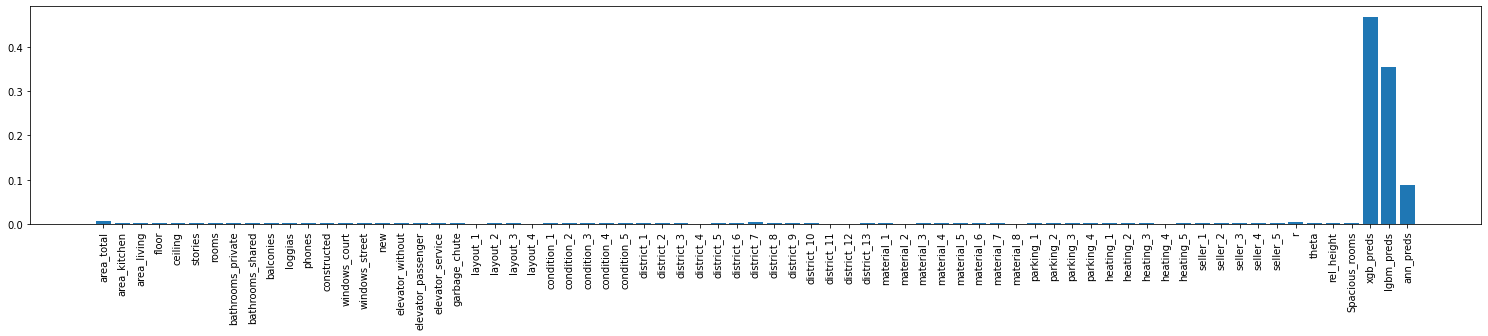

In [197]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), xgb_king.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [199]:
# king_prediction_1 uses ann, xgboost and lgboost advisors.
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="ensemble_predictions/simple_stack_prediction_1", exponential=True)